In [1]:
import os
import torch, torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
# root_dir = '/home/seannang/code/emotion_recognition/dataset/basic/Image'
from getDataset import *
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224,224)),
                                transforms.CenterCrop(180),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.4681,0.4030,0.5275], std=[1.5016,1.5685,1.5956])])
train_set = RAF_Dataset(csv_file= '/mnt/emotion_recognition/dataset/basic/Image/train_set/train_label.csv',
                        root_dir='/mnt/emotion_recognition/dataset/basic/Image/train',
                        transform = transform)

In [4]:
class_count = [1290,281,717,4772,1982,705,2524]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)

In [3]:
train_loaders = torch.utils.data.DataLoader(train_set,batch_size=64,shuffle=True)
images,labels=next(iter(train_loaders))

In [5]:
surprise = fear = disgust = happiness = sadness = anger = neutral = 0
for images, labels in train_loaders:
    surprise += torch.sum(labels==0)
    fear += torch.sum(labels==1)
    disgust += torch.sum(labels==2)
    happiness += torch.sum(labels==3)
    sadness += torch.sum(labels==4)
    anger += torch.sum(labels==5)
    neutral += torch.sum(labels==6)

KeyboardInterrupt: 

In [6]:
model = torchvision.models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100.0%


In [7]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
optim = torch.optim.SGD(model.parameters(),lr=1e-3)
crit=nn.CrossEntropyLoss()
scalar = torch.cuda.amp.GradScaler()

In [9]:
num_epoches = 50
total_step = len(train_loaders)
losses=[]
train_acc=[]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
for epoch in range(num_epoches):
    for i,(images,labels) in enumerate(train_loaders):
        images = images.to(device)
        labels = labels.to(device)
        model = model.to(device)
        optim.zero_grad()
        with torch.cuda.amp.autocast():
            outputs=model(images)
            loss=crit(outputs,labels)
        loss.backward()
        optim.step()
        _,argmax=torch.max(outputs,1)
        acc=(labels==argmax.squeeze()).float().mean()
        losses.append(loss.item()/total_step)
        train_acc.append(acc.item())

        if(i+1)%37==1:
            print('Epoch[{}/{}],Step[{}/{}],Loss:{:.4f},Accuracy:{:.3f}'
                  .format(epoch+1,num_epoches,i+1,total_step,loss.item(),acc.item()))

Epoch[1/50],Step[1/192],Loss:9.9627,Accuracy:0.000
Epoch[1/50],Step[38/192],Loss:5.0566,Accuracy:0.188
Epoch[1/50],Step[75/192],Loss:3.4310,Accuracy:0.344
Epoch[1/50],Step[112/192],Loss:2.5237,Accuracy:0.438
Epoch[1/50],Step[149/192],Loss:1.7912,Accuracy:0.531
Epoch[1/50],Step[186/192],Loss:2.1621,Accuracy:0.516
Epoch[2/50],Step[1/192],Loss:1.9308,Accuracy:0.547
Epoch[2/50],Step[38/192],Loss:1.3658,Accuracy:0.562
Epoch[2/50],Step[75/192],Loss:1.3962,Accuracy:0.625
Epoch[2/50],Step[112/192],Loss:1.2392,Accuracy:0.641
Epoch[2/50],Step[149/192],Loss:1.5736,Accuracy:0.547
Epoch[2/50],Step[186/192],Loss:1.2969,Accuracy:0.578
Epoch[3/50],Step[1/192],Loss:1.0832,Accuracy:0.656
Epoch[3/50],Step[38/192],Loss:1.1966,Accuracy:0.609
Epoch[3/50],Step[75/192],Loss:0.8267,Accuracy:0.703
Epoch[3/50],Step[112/192],Loss:1.2589,Accuracy:0.578
Epoch[3/50],Step[149/192],Loss:1.0106,Accuracy:0.656
Epoch[3/50],Step[186/192],Loss:1.0717,Accuracy:0.625
Epoch[4/50],Step[1/192],Loss:0.8053,Accuracy:0.828
Epoch[4

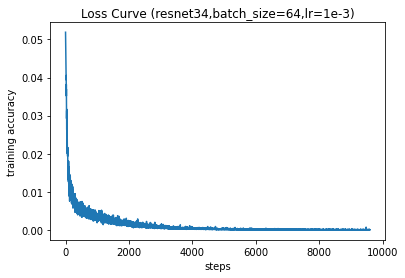

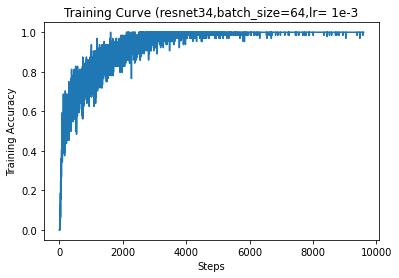

In [13]:
plt.plot(losses)
plt.title('Loss Curve (resnet34,batch_size=64,lr=1e-3)')
plt.xlabel('steps')
plt.ylabel('training accuracy')
plt.show()

plt.plot(train_acc)
plt.title("Training Curve (resnet34,batch_size=64,lr= 1e-3")
plt.xlabel("Steps")
plt.ylabel("Training Accuracy")
plt.show()

In [20]:
test_set = RAF_Dataset(csv_file= '/mnt/emotion_recognition/dataset/basic/Image/test_label.csv',
                        root_dir='/mnt/emotion_recognition/dataset/basic/Image/test',
                        transform = transform)
test_loaders=torch.utils.data.DataLoader(test_set,batch_size=64,shuffle=False)

In [19]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images1, labels1 in test_loaders:
        images1 = images1.to(device)
        labels1 = labels1.to(device)
        model = model.to(device)
        outputs1 = model(images1)
        _, predicted = torch.max(outputs1.data, 1)
        total += labels1.size(0)
        correct += (predicted == labels1).sum().item()
    
    print('Accuracy of model is : {} %' .format(100*correct/total))

Accuracy of model is : 72.61167264427779 %


In [22]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loaders):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([[2.3600e+02, 5.0000e+00, 5.0000e+00, 1.5000e+01, 1.8000e+01, 9.0000e+00,
         4.1000e+01],
        [1.9000e+01, 2.7000e+01, 1.0000e+00, 6.0000e+00, 7.0000e+00, 7.0000e+00,
         7.0000e+00],
        [1.0000e+01, 0.0000e+00, 4.5000e+01, 1.8000e+01, 2.9000e+01, 9.0000e+00,
         4.9000e+01],
        [1.7000e+01, 3.0000e+00, 1.6000e+01, 1.0140e+03, 3.2000e+01, 1.4000e+01,
         8.9000e+01],
        [1.4000e+01, 3.0000e+00, 2.3000e+01, 4.2000e+01, 3.0400e+02, 1.2000e+01,
         7.9000e+01],
        [1.2000e+01, 3.0000e+00, 1.1000e+01, 1.6000e+01, 1.1000e+01, 9.3000e+01,
         1.6000e+01],
        [3.2000e+01, 3.0000e+00, 2.2000e+01, 4.8000e+01, 6.1000e+01, 6.0000e+00,
         5.0800e+02]])
tensor([0.7173, 0.3649, 0.2812, 0.8557, 0.6373, 0.5741, 0.7471])


Text(0.5, 69.0, 'Predicted label')

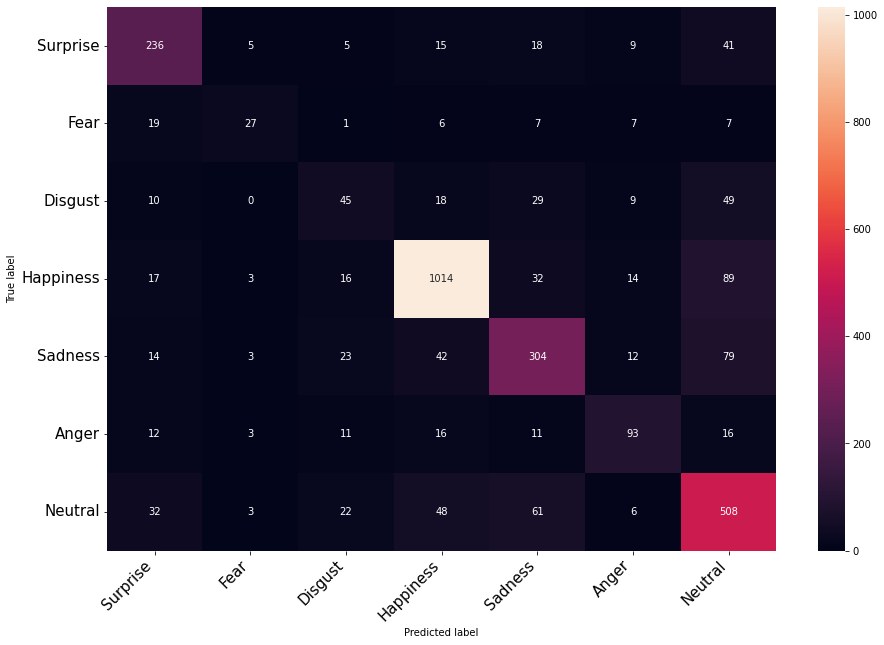

In [23]:
plt.figure(figsize=(15,10))


class_names = ['Surprise' , 'Fear' , 'Disgust' , 'Happiness' , 'Sadness' ,'Anger' ,'Neutral']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [24]:
torch.save('model.state_dict' , 'resnet34.pth')